#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. 

Нужно построить модель для такого предсказания где значение метрики *RMSE* на тестовой выборке не больше 48.

Необходимо:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Предобработка данных</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение-и-Тестирование-моделей" data-toc-modified-id="Обучение-и-Тестирование-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение и Тестирование моделей</a></span><ul class="toc-item"><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#DecisionTreeRegressor" data-toc-modified-id="DecisionTreeRegressor-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>DecisionTreeRegressor</a></span></li><li><span><a href="#RandomForestRegressor" data-toc-modified-id="RandomForestRegressor-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>RandomForestRegressor</a></span></li></ul></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

## Подготовка

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import numpy as np

# ---- ВРЕМЕННОЕ РЕШЕНИЕ ИЗ-ЗА ПРОБЛЕМ НА СТОРОНЕ ЯНДЕКСА --------
# stackoverflow.com/questions/71106940/cannot-import-name-centered-from-scipy-signal-signaltools
import scipy.signal.signaltools

def _centered(arr, newsize):
    # Return the center newsize portion of the array.
    newsize = np.asarray(newsize)
    currsize = np.array(arr.shape)
    startind = (currsize - newsize) // 2
    endind = startind + newsize
    myslice = [slice(startind[k], endind[k]) for k in range(len(endind))]
    return arr[tuple(myslice)]

scipy.signal.signaltools._centered = _centered

from statsmodels.tsa.seasonal import seasonal_decompose
# ----------------------------------------------------------------

from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

Путь к файлу `/datasets/taxi.csv`  
Подключим к проекту файл с данными и преобразуем данные с датой, для этого в функцию `read_csv()` добавим аргумент `parse_dates` 

In [2]:
data = pd.read_csv('/datasets/taxi.csv', parse_dates=[0])

Посмотрм на общие данные с помощью `.info()`

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


Всего в файле содержится `2` колонки и `26496` записи:
- `datetime` — дата и время
- `num_orders` — количество заказов

Выведем на экран первые 5 записей

In [4]:
data.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


### Предобработка данных

Установим новый индекс таблицы и отсортируем его

In [5]:
data = data.set_index('datetime')

In [6]:
data.sort_index(inplace=True)

Чтобы поменять интервал и сгруппировать значения, вызовем функцию `resample()`

In [7]:
data = data.resample('1H').sum()

Чтобы проверить, в хронологическом ли порядке расположены даты и время, посмотрим атрибут индекса таблицы с помощью `is_monotonic`

In [8]:
data.index.is_monotonic

True

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


## Анализ

Посмотрим на график распределения заказов

In [10]:
def display_plot(data, title):
    data.plot(
              figsize=(20,7),
              legend = True,
              alpha = 0.7,
             )
    plt.title(f'{title}', fontsize="xx-large")
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=4, fontsize="xx-large")
    plt.show()

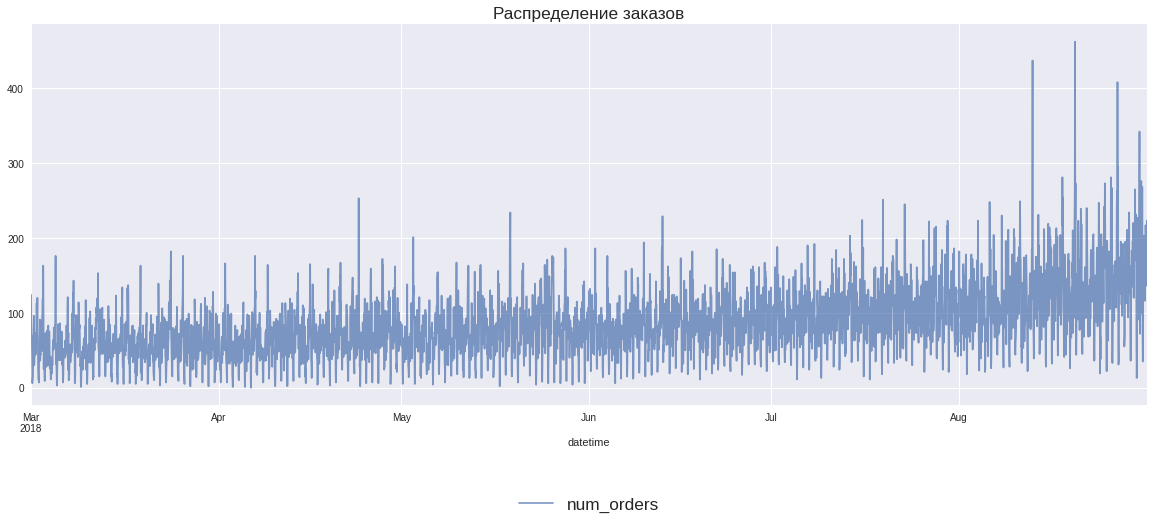

In [11]:
display_plot(data['num_orders'], "Распределение заказов")

Создадим копию датафрейма и проведем ресемплирование по часам.
Найдем скользящее среднее и вывдем график с новыми данными

In [12]:
data_new = data.copy()
data_new = data_new.resample('1H').sum()
data_new['rolling_mean'] = data_new['num_orders'].shift().rolling(100).mean()
data_new['std'] = data_new['num_orders'].rolling(100).std()
data_new = data_new.dropna()

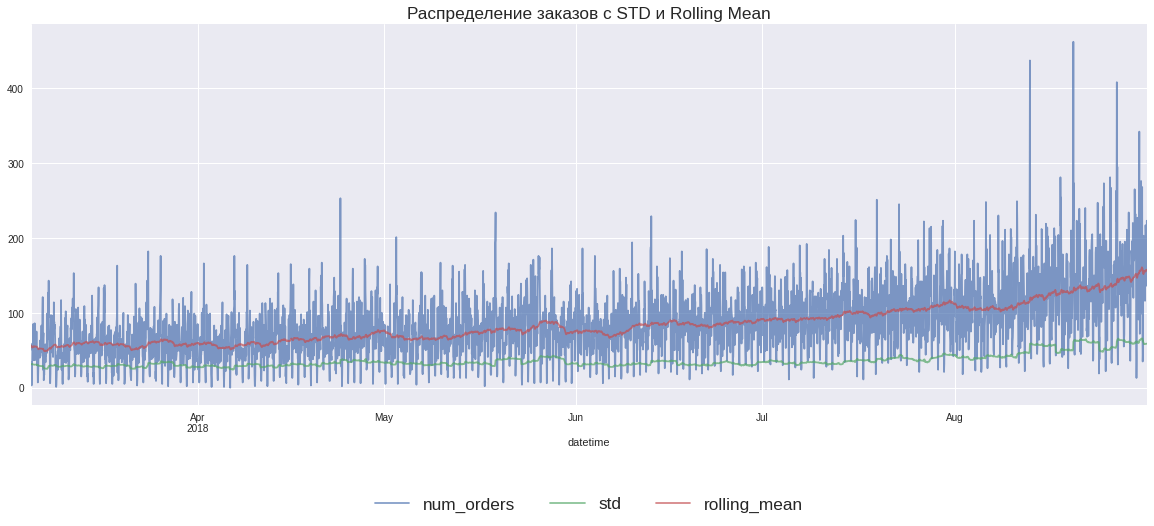

In [13]:
display_plot(data_new[['num_orders', 'std', 'rolling_mean']],
             "Распределение заказов с STD и Rolling Mean")

На полученом графике видим что среднее значение (красный) и стандартное отклонение (зеленый) со временем увеличиваются, значит временной ряд нестационарный.  
Так же заметен тренд на увеличение количества заказов от месяца к месяцу

Для более наглядного отображения тренда и сезонности проведем декомпозицию.

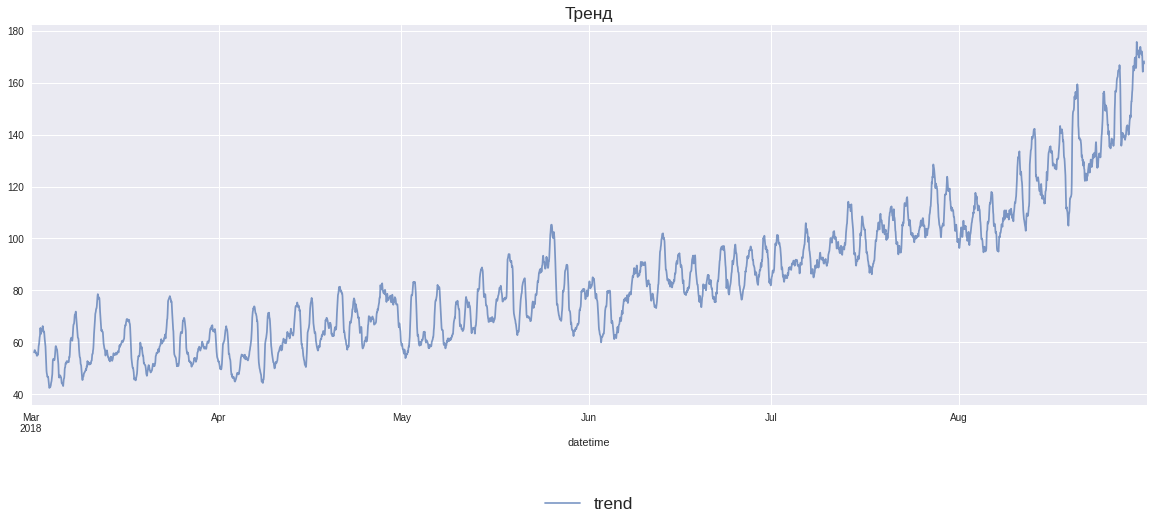

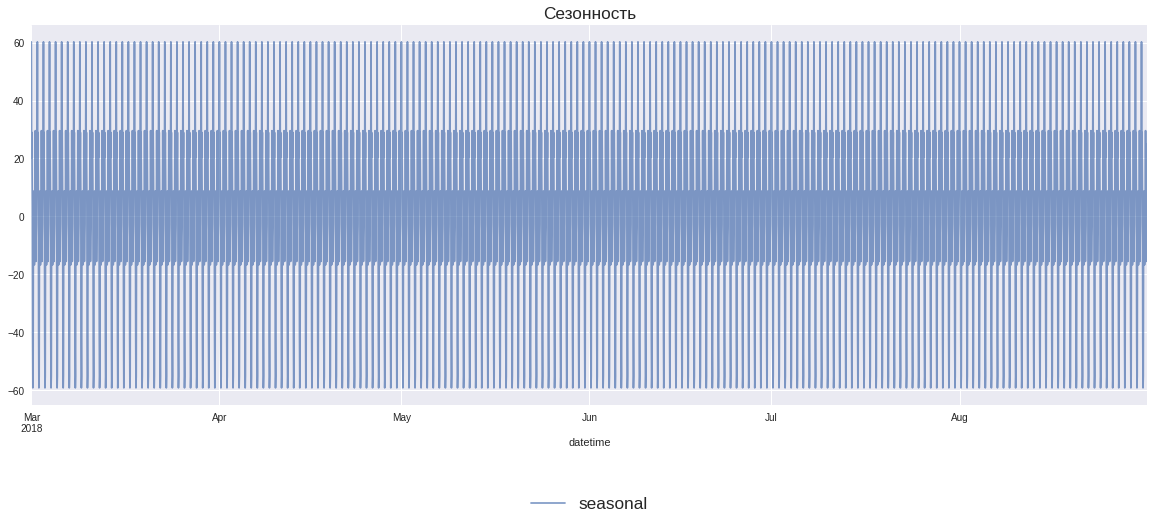

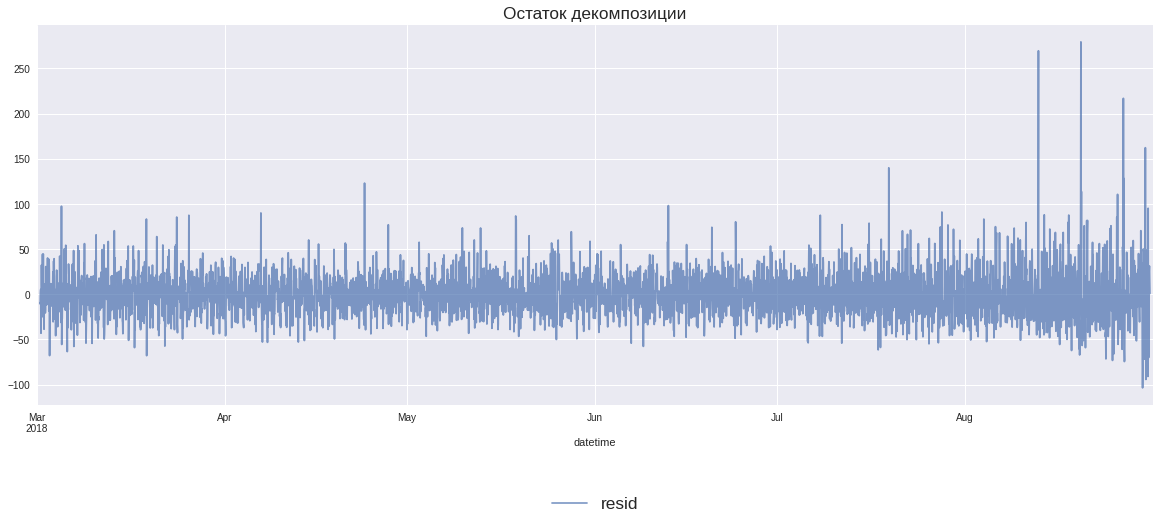

In [14]:
decomposed = seasonal_decompose(data)

def decomposed_graphs(decomposed_data, title):
    decomposed_data.plot(
              figsize=(20,7),
              legend = True,
              alpha = 0.7,
             )
    plt.title(f'{title}', fontsize="xx-large")
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=4, fontsize="xx-large")
    plt.show()

decomposed_graphs(decomposed.trend, "Тренд")
decomposed_graphs(decomposed.seasonal, "Сезонность")
decomposed_graphs(decomposed.resid, "Остаток декомпозиции")

По данным графикам можно сделать вывод, что присутствует сезонность, **график стационарен**, и восходящий тренд, **колличество заказов такси уверенно увеличивается**

Посмотрим на еще одни график, дневной "сезонности"

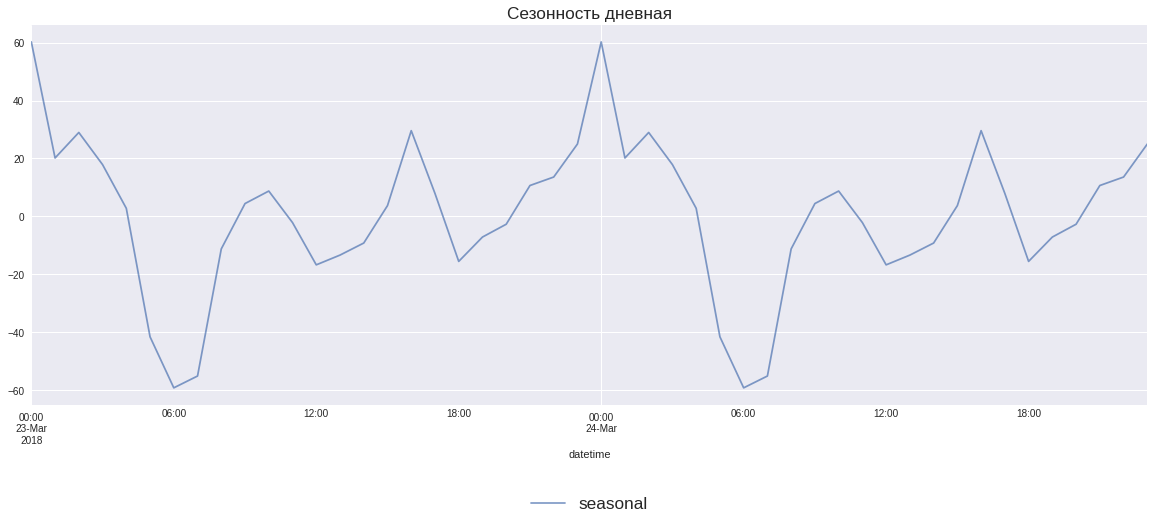

In [15]:
decomposed_graphs(decomposed.seasonal['2018-03-23':'2018-03-24'], "Сезонность дневная")

Как видно из графика, реже всего заказ такси приходит на 6 утра, начиная с 18 часов виден рост значений до пикового на полночь. После чего количество заказов резко начинает сокращаться.  
Возможно, такое поведение связано со спецификой работы трансопрта в аэропорту, когда утром можно доехать на автобусах, поезде, а вечером и ближе к ночи общественный транспорт ходит реже, соответственно спрос на такси существенно растет.

## Обучение и Тестирование моделей

Создадим в датафрейме новые признаки: календарные, отстающие значения и скользящее среднее.

In [16]:
def make_features(data, lag_n, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, lag_n + 1):
        data[f'lag_{lag}'] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    data.dropna(inplace=True)

In [17]:
make_features(data, 10, 10)

In [18]:
data.head()

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,rolling_mean
datetime,,,,,,,,,,,,,,,,
2018-03-01 10:00:00,64,3,1,3,10,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,52.5
2018-03-01 11:00:00,96,3,1,3,11,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,46.5
2018-03-01 12:00:00,30,3,1,3,12,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,47.6
2018-03-01 13:00:00,32,3,1,3,13,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,43.5
2018-03-01 14:00:00,48,3,1,3,14,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,40.1


Разделим данные на обучающую и тестовую выборки, удалим строки с пропусками

In [19]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

Напишем функцию которая будет получать название модели, модель и ее гиперапараметры после проведет подсчет и выведет на экран RMSE для учебной и тестовой выборки.

In [20]:
def rmse(model, title):
    model = model
    model.fit(features_train, target_train)
    train_pred = model.predict(features_train)
    test_pred = model.predict(features_test)
    RMSE_train = mean_squared_error(target_train, train_pred)**0.5
    RMSE_test = mean_squared_error(target_test, test_pred)**0.5

    print(f"Модель: {title}\n"
          f"RMSE на обучающей выборке: {RMSE_train}\n"
          f"RMSE на тестовой выборке: {RMSE_test}\n")

---

### LinearRegression

In [21]:
%%time
rmse(LinearRegression(), 'LinearRegression')

Модель: LinearRegression
RMSE на обучающей выборке: 30.22368381335574
RMSE на тестовой выборке: 53.51571051157058

CPU times: user 45.6 ms, sys: 95.9 ms, total: 141 ms
Wall time: 54.8 ms


---

### DecisionTreeRegressor

Перебор гиперапараметров закомментирован, а результат вычислений вынесен ниже в отдельной ячейке.

In [25]:
tss = TimeSeriesSplit(n_splits=5)

In [26]:
dtr_params = {
        'max_depth' : range(1, 100),
        'random_state' : [12345] 
        }

In [27]:
%%time
dtr_grid = GridSearchCV(DecisionTreeRegressor(),
                        param_grid = dtr_params,
                        refit=False,
                        scoring='neg_mean_squared_error',
                        cv=tss
                       )
dtr_grid.fit(features_train, target_train)

dtr_best_params = dtr_grid.best_params_
dtr_model = DecisionTreeRegressor(**dtr_best_params)
dtr_model.fit(features_train, target_train)
    
dtr_test_pred = dtr_model.predict(features_test)

print(f"Лучшие гиперпараметры: {dtr_best_params}")
print(f"RMSE тестовой выборки: {mean_squared_error(target_test, dtr_test_pred)**0.5}")

Лучшие гиперпараметры: {'max_depth': 7, 'random_state': 12345}
RMSE тестовой выборки: 49.45251273646661
CPU times: user 15.6 s, sys: 4.25 ms, total: 15.6 s
Wall time: 16.3 s


In [28]:
%%time
rmse(DecisionTreeRegressor(max_depth = 7, random_state = 12345), 'DecisionTreeRegressor')

Модель: DecisionTreeRegressor
RMSE на обучающей выборке: 21.778406464756696
RMSE на тестовой выборке: 49.45251273646661

CPU times: user 36.4 ms, sys: 168 µs, total: 36.6 ms
Wall time: 34 ms


---

### RandomForestRegressor

Перебор гиперапараметров закомментирован, а результат вычислений вынесен ниже в отдельной ячейке.

In [30]:
rfr_params = {
        'n_estimators' : range(50, 101, 10),
        'max_depth' : range(5, 25, 2),
        'verbose' : [0],
        'random_state' : [12345] 
        }

In [31]:
%%time
rfr_grid = GridSearchCV(RandomForestRegressor(),
                        param_grid = rfr_params,
                        refit=False,
                        scoring='neg_mean_squared_error',
                        cv=tss
                       )
rfr_grid.fit(features_train, target_train)

rfr_best_params = rfr_grid.best_params_
rfr_model = RandomForestRegressor(**rfr_best_params)
rfr_model.fit(features_train, target_train)
    
rfr_test_pred = dtr_model.predict(features_test)

print(f"Лучшие гиперпараметры: {rfr_best_params}")
print(f"RMSE тестовой выборки: {mean_squared_error(target_test, rfr_test_pred)**0.5}")

Лучшие гиперпараметры: {'max_depth': 23, 'n_estimators': 80, 'random_state': 12345, 'verbose': 0}
RMSE тестовой выборки: 49.45251273646661
CPU times: user 5min 25s, sys: 955 ms, total: 5min 26s
Wall time: 5min 30s


---

In [32]:
%%time
rmse(RandomForestRegressor(n_estimators = 80,
                           max_depth = 23,
                           random_state = 12345), 'RandomForestRegressor')

Модель: RandomForestRegressor
RMSE на обучающей выборке: 8.582980147844534
RMSE на тестовой выборке: 44.45044279937339

CPU times: user 2.84 s, sys: 16 ms, total: 2.85 s
Wall time: 2.87 s


## Общий вывод

В итоге исследования были получены следующие результаты:

| Model name            	| RMSE Test         	| RMSE Train         	| Depth 	| EST  	|
|:-----------------------	|:-------------------:	|--------------------	|-------	|------	|
| LinearRegression      	| 53.51571051157058 	| 30.22368381335574  	| ----  	| ---- 	|
| DecisionTreeRegressor 	| 48.08733972353548 	| 13.849317412647133 	| 11    	| ---- 	|
| RandomForestRegressor 	| 43.80042268131265 	| 8.658164216422168  	| 19    	| 95   	|

По полученым результатам можно сделать вывод, что модели `DecisionTreeRegressor` и `RandomForestRegressor`  показывают достаточно хорошее качество предсказаний, но лучшей показала себя `RandomForestRegressor` как на учебной так и на тестовой выборке.

Таких показателей удалось достичь с перебором различных гиперапараметров у моделей, итогом стала модель `RandomForestRegressor` с гиперпараметрами `n_estimators = 95`, `max_depth = 19` а итоговым `RMSE = 
43.80042268131265`